In [2]:
from utils.dataloader import DataPartitions, DataGenerator
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [3]:
partitions = DataPartitions(
    past_frames=4, 
    future_frames=8, 
    root="../datasets/arda/04_21_full/"
)

In [3]:
dataset = DataGenerator(
    root="../datasets/arda/04_21_full/", 
    filenames=partitions.get_areas(), 
    dataset_partitions=partitions.get_train(), 
    past_frames=partitions.past_frames, 
    future_frames=partitions.future_frames, 
    input_dim=(partitions.past_frames, 256, 256, 3),  
    output_dim=(partitions.future_frames, 256, 256, 1), 
    batch_size=16, 
    n_channels=1, 
    shuffle=True,
    buffer_size = 1e3,
    buffer_memory = 100
)

In [4]:
X = dataset.get_X()
Y = dataset.get_Y()

X[X > 10e5] = 0 
Y[Y > 10e5] = 0 

100%|██████████| 16/16 [00:33<00:00,  2.08s/it]


In [45]:
Y.shape

(16, 16, 8, 256, 256, 1)

In [56]:
partitions.get_areas()

['mini-211-466-421-676',
 'mini-211-466-456-711',
 'mini-246-501-421-676',
 'mini-246-501-456-711',
 'mini-246-501-491-746',
 'mini-281-536-421-676',
 'mini-281-536-456-711',
 'mini-281-536-491-746',
 'mini-281-536-526-781',
 'mini-316-571-421-676',
 'mini-316-571-456-711',
 'mini-316-571-491-746',
 'mini-316-571-526-781',
 'mini-316-571-561-816',
 'mini-316-571-596-851',
 'mini-316-571-631-886']

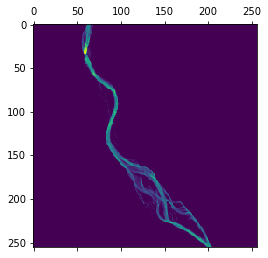

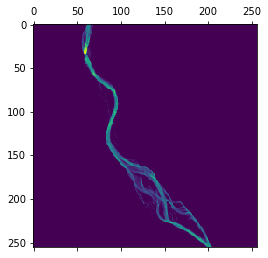

In [52]:
i = 8
plt.matshow(X[0, i, 0, :, :, 0])
plt.matshow(Y[0, i, 7, :, :, 0])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [6]:
sc_img = StandardScaler() # image
sc_vvx = StandardScaler() # vvx
sc_vvy = StandardScaler() # vvy

for sample in X_train:
    for batch in sample:
        for frame in batch:
            sc_img.partial_fit(frame[:,:,0])
            sc_vvx.partial_fit(frame[:,:,1])
            sc_vvy.partial_fit(frame[:,:,1])

In [7]:
for s, sample in enumerate(X_train):
    for b, batch in enumerate(sample):
        for f, frame in enumerate(batch):
            X_train[s, b, f, :, :, 0] = sc_img.transform(frame[:,:,0])
            X_train[s, b, f, :, :, 1] = sc_vvx.transform(frame[:,:,1])
            X_train[s, b, f, :, :, 2] = sc_vvy.transform(frame[:,:,2])
            
print("X_train ready")        

for s, sample in enumerate(X_test):
    for b, batch in enumerate(sample):
        for f, frame in enumerate(batch):
            X_test[s, b, f, :, :, 0] = sc_img.transform(frame[:,:,0])
            X_test[s, b, f, :, :, 1] = sc_vvx.transform(frame[:,:,1])
            X_test[s, b, f, :, :, 2] = sc_vvy.transform(frame[:,:,2])
            
print("X_test transformed")
            
for s, sample in enumerate(y_train):
    for b, batch in enumerate(sample):
        for f, frame in enumerate(batch):
            y_train[s, b, f, :, :, 0] = sc_img.transform(frame[:,:,0])
  
print("y_train transformed")

for s, sample in enumerate(y_test):
    for b, batch in enumerate(sample):
        for f, frame in enumerate(batch):
            y_test[s, b, f, :, :, 0] = sc_img.transform(frame[:,:,0])
            
print("y_test transformed")

X_train ready
X_test transformed
y_train transformed
y_test transformed


In [31]:
X_test.shape

torch.Size([5, 16, 3, 4, 256, 256])

### Model

In [9]:
import numpy as np

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

In [10]:
if th.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = th.device(dev) 

In [11]:
class ResNetBlock(nn.Module):
        
    def __init__(self, in_filters, filters, stride):
        super(ResNetBlock, self).__init__()
        
        self.activation = nn.ReLU()
        self.c1 = nn.Conv3d(in_filters, filters, (3, 3, 3), stride, padding=1)
        self.c2 = nn.Conv3d(filters, filters, (3, 3, 3), padding=1)
        self.c3 = nn.Conv3d(in_filters, filters, (1, 1, 1), stride)
        
        self.bn = nn.BatchNorm3d(num_features=filters)

    def forward(self, x,):
        
        residual = x
        
        y = self.c1(x)

        y = self.bn(y)
        y = self.activation(y)
        y = self.c2(y)
        y = self.bn(y)

        # reshape
        if residual.shape != y.shape:
            residual = self.c3(residual)
            residual = self.bn(residual)
            
        return self.activation(residual + y)


In [12]:
class ResTransBlock(nn.Module):
        
    def __init__(self, in_filters, filters, stride):
        super(ResTransBlock, self).__init__()
        
        self.activation = nn.ReLU()
        self.c1 = nn.ConvTranspose3d(in_filters, filters, (3, 3, 3), stride)
        self.c2 = nn.ConvTranspose3d(filters, filters, (3, 3, 3))
        self.c3 = nn.ConvTranspose3d(in_filters, filters, (3,3,3), stride)
        
        self.bn = nn.BatchNorm3d(1000)

    def forward(self, x,):
        
        residual = x
        print(residual.shape)
        
        y = self.c1(x)

        y = self.b
        y = self.activation(y)
        y = self.c2(y)
        # batchnorm here

        # reshape
        if residual.shape != y.shape:
            residual = self.c3(residual)
            # batchnorm here
            
        print(y.shape)
        print(residual.shape)
            
        return self.activation(residual + y)


In [13]:
class Autoencoder(nn.Module):
    
    def __init__(self, channels, past_frames, future_frames):
        super(Autoencoder, self).__init__()
        

        self.layers = nn.ModuleList([
            nn.Conv3d(channels, 64, (3,3,3), stride=2, padding=1),
            nn.AvgPool3d((2,2,2)),
            
            ResNetBlock(in_filters = 64, filters = 64, stride = 2),
            ResNetBlock(in_filters = 64, filters = 64, stride = 2),

            nn.Conv3d(64, 128, (1,1,1)),
            ResNetBlock(in_filters = 128, filters = 128, stride = 2),
            ResNetBlock(in_filters = 128, filters = 128, stride = 2),

            nn.Conv3d(128, 256, (1,1,1)),
            ResNetBlock(in_filters = 256, filters = 256, stride = 2),
            ResNetBlock(in_filters = 256, filters = 256, stride = 2), 
            
            
            nn.Conv3d(256, 512, (1,1,1)),
            ResNetBlock(in_filters = 512, filters = 512, stride = 2),
            ResNetBlock(in_filters = 512, filters = 512, stride = 2),
            
            
            nn.ConvTranspose3d(512, 512, (1,2,2), stride=(1,2,2)),
            nn.ConvTranspose3d(512, 256, (1,2,2), stride=(1,2,2)),
            nn.BatchNorm3d(num_features=256),
            
            nn.ConvTranspose3d(256, 256, (1,2,2), stride=(1,2,2)),
            nn.ConvTranspose3d(256, 128, (1,2,2), stride=(1,2,2)),
            nn.BatchNorm3d(num_features=128),
            
            nn.ConvTranspose3d(128, 128, (1,2,2), stride=(1,2,2)),
            nn.ConvTranspose3d(128, 128, (1,2,2), stride=(1,2,2)),
            nn.ConvTranspose3d(128, 64, (2,2,2), stride=(1,2,2)),
            nn.BatchNorm3d(num_features=64),
            
            nn.ConvTranspose3d(64, 64, (2,1,1), stride=(2,1,1)),
            nn.BatchNorm3d(num_features=64),
            
            nn.ConvTranspose3d(64, 1, (2,2,2), stride=(2,2,2)),
            
        ])
    
    def forward(self, x, summary = False):
        
        if summary:
            print("==== Model Summary ====")
            print("{:<15s}{:>4s}".format("Block", "Output shape"))

        for i, l in enumerate(self.layers):
            x = l(x)
            
            if summary:
                print("{:<20s}{:>4s}".format(
                    str(l).split("(")[0],
                    str(x.shape).split("[")[1].split("]")[0]
                ))
        
        return x

In [14]:
net = Autoencoder(3, 4, 4).to(device)
net(th.Tensor(np.random.random((16, 3, 4, 256, 256))).to(device), True).shape

==== Model Summary ====
Block          Output shape
Conv3d              16, 64, 2, 128, 128
AvgPool3d           16, 64, 1, 64, 64
ResNetBlock         16, 64, 1, 32, 32
ResNetBlock         16, 64, 1, 16, 16
Conv3d              16, 128, 1, 16, 16
ResNetBlock         16, 128, 1, 8, 8
ResNetBlock         16, 128, 1, 4, 4
Conv3d              16, 256, 1, 4, 4
ResNetBlock         16, 256, 1, 2, 2
ResNetBlock         16, 256, 1, 1, 1
Conv3d              16, 512, 1, 1, 1
ResNetBlock         16, 512, 1, 1, 1
ResNetBlock         16, 512, 1, 1, 1
ConvTranspose3d     16, 512, 1, 2, 2
ConvTranspose3d     16, 256, 1, 4, 4
BatchNorm3d         16, 256, 1, 4, 4
ConvTranspose3d     16, 256, 1, 8, 8
ConvTranspose3d     16, 128, 1, 16, 16
BatchNorm3d         16, 128, 1, 16, 16
ConvTranspose3d     16, 128, 1, 32, 32
ConvTranspose3d     16, 128, 1, 64, 64
ConvTranspose3d     16, 64, 2, 128, 128
BatchNorm3d         16, 64, 2, 128, 128
ConvTranspose3d     16, 64, 4, 128, 128
BatchNorm3d         16, 64, 4, 128,

torch.Size([16, 1, 8, 256, 256])

In [15]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=10e-3)

In [16]:
X_train = th.Tensor(X_train).to(device)
y_train = th.Tensor(y_train).to(device)

In [17]:
X_train = X_train.permute(0, 1, 5, 2, 3, 4)
y_train = y_train.permute(0, 1, 5, 2, 3, 4)

In [18]:
X_test = th.Tensor(X_test).to(device)
y_test = th.Tensor(y_test).to(device)

In [19]:
X_test = X_test.permute(0, 1, 5, 2, 3, 4)
y_test = y_test.permute(0, 1, 5, 2, 3, 4)

In [20]:
def relative_error(y, y_true):
    return (th.norm(y - y_true, float('inf')) / th.norm(y_true, float('inf')))

In [21]:
losses = []
errors = []
test_errors = []

In [22]:
epochs = 50

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(X_train):
        
        optimizer.zero_grad()

        outputs = net(batch)
        
        loss = criterion(outputs, y_train[i])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        losses.append(loss.item())
        
        if epoch % 5 == 0:
            # randomly pick a test batch and compute it
            i = np.random.randint(len(y_test), size=1)
            
            train_out = net(X_test[i][0])
            test_out = net(X_train[i][0])
            
            train_err = relative_error(train_out, y_train[i]).item()
            test_err = relative_error(test_out, y_test[i]).item()
        
            test_errors.append(test_err)
            errors.append(train_err)
            
            print('[%d, %5d] train_err: %.3f \t  test_err: %.3f' %
                  (epoch + 1, i + 1, train_err, test_err))
    
        #if epoch % 10 == 0:
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0

print('Finished Training')

[1,     1] train_err: 1.018 	  test_err: 1.020
[1,     5] train_err: 1.047 	  test_err: 1.007
[1,     2] train_err: 1.045 	  test_err: 1.555
[1,     3] train_err: 1.781 	  test_err: 2.915
[1,     2] train_err: 1.006 	  test_err: 1.336
[1,     3] train_err: 1.006 	  test_err: 1.008
[1,     4] train_err: 1.021 	  test_err: 1.014
[1,     4] train_err: 1.013 	  test_err: 1.013
[1,     1] train_err: 1.003 	  test_err: 1.002
[1,     3] train_err: 1.002 	  test_err: 1.003
[1,     5] train_err: 1.007 	  test_err: 1.002
[6,     1] train_err: 1.002 	  test_err: 1.000
[6,     3] train_err: 1.001 	  test_err: 1.003
[6,     1] train_err: 1.001 	  test_err: 1.000
[6,     1] train_err: 1.001 	  test_err: 1.000
[6,     1] train_err: 1.002 	  test_err: 1.000
[6,     1] train_err: 1.003 	  test_err: 1.000
[6,     1] train_err: 1.002 	  test_err: 1.000
[6,     2] train_err: 1.000 	  test_err: 0.984
[6,     3] train_err: 1.000 	  test_err: 1.002
[6,     5] train_err: 0.942 	  test_err: 0.995
[6,     3] tr

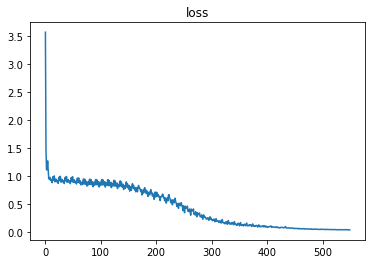

In [23]:
plt.title("loss")
plt.plot(range(len(losses)), losses)
pass

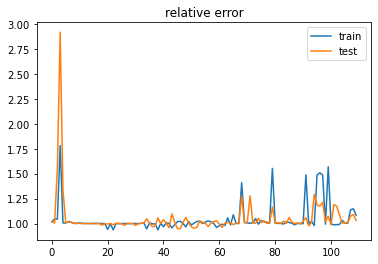

In [24]:
plt.title("relative error")
plt.plot(range(len(errors)), errors, label="train")
plt.plot(range(len(test_errors)), test_errors, label="test")
plt.legend()
pass

In [25]:
i = np.random.randint(len(X_test))
i

3

In [26]:
outputs = net(X_test[i])

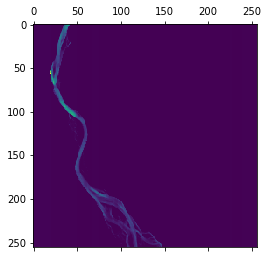

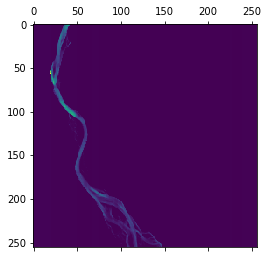

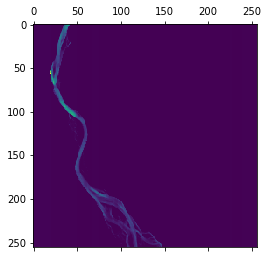

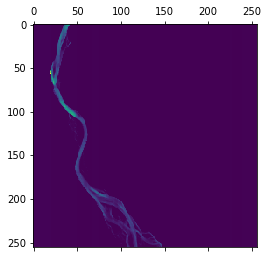

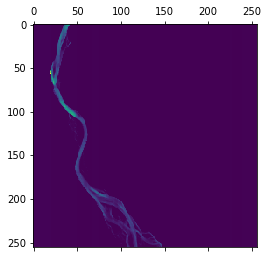

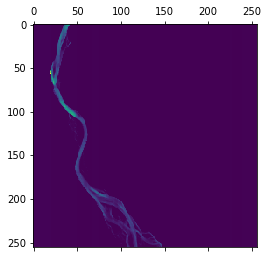

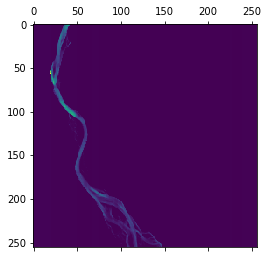

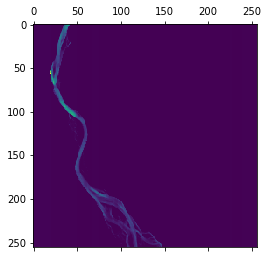

In [27]:
for frame in y_test[i][0][0]:
    plt.matshow(frame.cpu().detach().numpy())

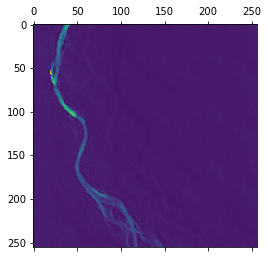

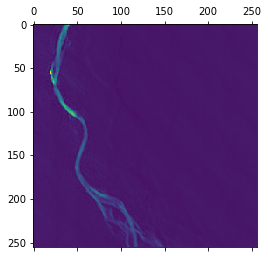

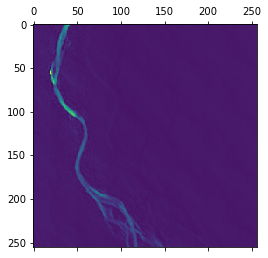

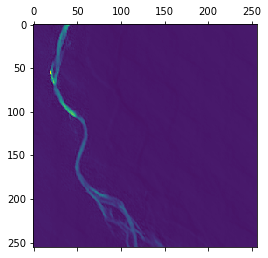

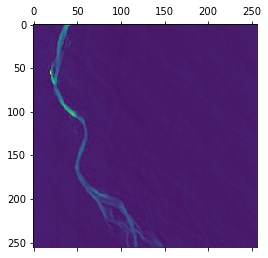

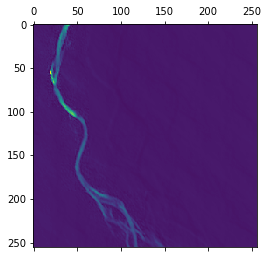

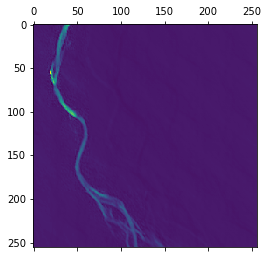

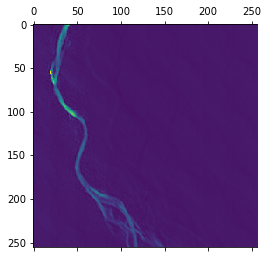

In [28]:
for frame in outputs[0][0]:
    plt.matshow(frame.cpu().detach().numpy())

In [29]:
print("{:<20s}{:<20s}{:<20s}{:<20s}{:<20s}".format("", "min", "max", "mean", "std"))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("prediction", th.min(outputs), th.max(outputs), th.mean(outputs), th.std(outputs)))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("true", th.min(y_test[0]), th.max(y_test[0]), th.mean(y_test[0]), th.std(y_test[0])))

                    min                 max                 mean                std                 
prediction          -2.761509           27.855795           0.002979            0.918610            
true                -0.287871           29.395178           -0.001334           0.946501            
